# Analyze DTI

In [108]:
# import packages
# -----------------------------------------------------------------------------
# import pip
# pip.main(['install', 'seaborn']) 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import subprocess
import sys
import json
import platform
import socket
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy import stats


In [109]:
# parameters
# -----------------------------------------------------------------------------
MANUALLY_EXCLUDE_SUBJECTS = []

running_on = 'server' if 'Linux' in platform.system() else 'my_mac'

if running_on == 'my_mac':
    data_path = '/Users/ranigera/Dropbox/DTI_tests'
    preproc_path = '/Users/ranigera/Dropbox/DTI_tests/preproc'
    dti_path = '/Users/ranigera/Dropbox/DTI_tests/dti'
    stats_path = '/Users/ranigera/Dropbox/DTI_tests/stats_alt_reg'
    models_path = stats_path + '/models'
    launch_files_path = '/Users/ranigera/Dropbox/DTI_analysis/launch_files'
else:
    data_path = '/export2/DATA/HIS/HIS_server/BIDS'
    preproc_path = '/export2/DATA/HIS/HIS_server/analysis/dwi_data/preproc'
    dti_path = '/export2/DATA/HIS/HIS_server/analysis/dwi_data/dti'
    stats_path = '/export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg'
    models_path = stats_path + '/models'
    launch_files_path = '/export2/DATA/HIS/HIS_server/codes_dwi/launch_files'
    behav_data_path = '/export2/DATA/HIS/HIS_server/analysis/behavior_analysis_output/my_databases/txt_data'

fmriPrepAnatomyDerivatives_path = data_path + '/derivatives/fmriprep'

expectedVolums = {
    'AP': 69,
    'PA' : 7,
    }
expectedB0s_indxs = {
    'AP_before': [0, 1, 18, 35, 52],
    'PA_before': [0, 2, 3, 4, 5, 6],
    'AP_after': [0, 1, 18, 35, 52],
    'PA_after': [0, 2, 3, 4, 5, 6]
    }

n_cores_TOPUP = 2

# setting EDDY stuff:
EDDY_command = 'eddy_openmp' if running_on == 'server' else 'eddy' # for the boost server
EDDY_command = 'eddy_cuda10.2' if running_on == 'server' else 'eddy' # for the cheshire server
ssh_command_for_cheshire_server = 'ssh shirangera@cheshire.tau.ac.il' if 'boost' in socket.gethostname() else ''

n_expected_EDDY_output_files = 13
n_cores_EDDY = 4 # relevant only for running using files (currently disabled as I run it on cheshire's GPU)

n_expected_DTIFIT_output_files = 10

masks_paths = {
    'Caudate': '/export2/DATA/HIS/HIS_server/DTI_assitance_files/masks/Harvard-Oxford/CaudateHead_Y-larger-than-1-mask.nii.gz',
    'Putamen': '/export2/DATA/HIS/HIS_server/DTI_assitance_files/masks/Harvard-Oxford/Putamen-mask.nii.gz',
    'vmPFC':   '/export2/DATA/HIS/HIS_server/DTI_assitance_files/masks/Harvard-Oxford/vmPFC-mask.nii.gz',
}

In [110]:
# added in this file to adjust some paths:
stats_path_NOTOPUP_EXCLUDED = stats_path + '_NOTOPUP_EXCLUDED'
models_path = os.path.join(stats_path_NOTOPUP_EXCLUDED, 'models')

In [15]:
# Define functions
# -----------------------------------------------------------------------------
def createSubjectScansBaseNames(subjFolder, data_path):
    sub = int(subjFolder.split("-",1)[1])
    group = '1day' if sub < 200 else '3day'
    last_sess = group[0]
    DWI_path_before = os.path.join(data_path, subjFolder, 'ses-1/dwi/')
    DWI_path_after = os.path.join(data_path, subjFolder, f'ses-{last_sess}/dwi/')
    scansBaseNames = {
        'AP_before': f'{os.path.join(DWI_path_before, "sub-" + str(sub) + "_ses-1_acq-ap_run-01_dwi")}',
        'PA_before' : f'{os.path.join(DWI_path_before, "sub-" + str(sub) + "_ses-1_acq-pa_run-01_dwi")}',
        'AP_after' : f'{os.path.join(DWI_path_after, "sub-" + str(sub) + "_ses-" + last_sess + "_acq-ap_run-02_dwi")}',
        'PA_after' : f'{os.path.join(DWI_path_after, "sub-" + str(sub) + "_ses-" + last_sess + "_acq-pa_run-02_dwi")}'
        }
    return scansBaseNames

def get_sub_B0_files(subjFolder, scansBaseNames, B0s_indxs):
    sub_B0s_files = []
    for scan in scansBaseNames.keys():
        for B0ind in B0s_indxs[scan]:
            B0_file_name = os.path.join(preproc_path, subjFolder, subjFolder + '_' + scan + "_b0_volInd-" + str(B0ind) + ".nii.gz")
            sub_B0s_files.append(B0_file_name)
    return sub_B0s_files


In [16]:
# Get folders and remove excluded subjects
# -----------------------------------------------------------------------------
print('>> Get sub folders')
subjFolders = [el for el in os.listdir(data_path) if 'sub' in el]

if running_on == 'my_mac':
    print('>> Get exclusion list')
    with open('/Users/ranigera/Google_Drive_TAU/Experiments/HIS_STUDY/Analysis/codes/paths_and_vars.py') as txtFile:
        txt = txtFile.read()
    participantsToExclude = [int(el) for el in txt.split('participantsToExclude = [')[1].split(']')[0].replace('\n','').replace('\n','').replace("'","").split(',')]

    print('>> Remove sub folders of excluded participants in case they are there')
    subjFolders = [el for el in subjFolders if int(el.split('-')[1]) not in participantsToExclude]

if MANUALLY_EXCLUDE_SUBJECTS:
    subjFolders = [el for el in subjFolders if int(el.split('-')[1]) not in MANUALLY_EXCLUDE_SUBJECTS]
    
subjFolders.sort()

>> Get sub folders


## Check for missing scans or wrong phase encoding directions for ALL SUBJECTS 

In [17]:
print ('>> Verify that all the scans exist and that the phase encoding directions are as they should.')
subjectsWithAProblem = []
for subjFolder in subjFolders:
    sub = int(subjFolder.split("-",1)[1])
    scansBaseNames = createSubjectScansBaseNames(subjFolder, data_path)
    for scan in scansBaseNames.keys():
        # print(scansBaseNames[scan] + '.json')
        # print(scanData['PhaseEncodingDirection'])
        if not os.path.exists(scansBaseNames[scan] + '.json'):
            subjectsWithAProblem.append(sub)
            print(' *** Scan not found: ' + scansBaseNames[scan] + '.json')
            continue
        with open(scansBaseNames[scan] + '.json') as json_file:        
            scanData = json.load(json_file)
            if ('acq-ap_' in scansBaseNames[scan] and scanData['PhaseEncodingDirection'] != 'j-') or \
                ('acq-pa_' in scansBaseNames[scan] and scanData['PhaseEncodingDirection'] != 'j'):
                subjectsWithAProblem.append(sub)
                print(' *** There is a problem with the scanning directions: ' + scansBaseNames[scan] + '.json is defined as ' + scanData['PhaseEncodingDirection'] + '.')
                continue

subjectsWithAProblem = list(set(subjectsWithAProblem))
subjectsWithAProblem.sort()

>> Verify that all the scans exist and that the phase encoding directions are as they should.
 *** There is a problem with the scanning directions: /export2/DATA/HIS/HIS_server/BIDS/sub-204/ses-3/dwi/sub-204_ses-3_acq-pa_run-02_dwi.json is defined as j-.
 *** There is a problem with the scanning directions: /export2/DATA/HIS/HIS_server/BIDS/sub-207/ses-1/dwi/sub-207_ses-1_acq-pa_run-01_dwi.json is defined as j-.
 *** There is a problem with the scanning directions: /export2/DATA/HIS/HIS_server/BIDS/sub-209/ses-1/dwi/sub-209_ses-1_acq-pa_run-01_dwi.json is defined as j-.
 *** Scan not found: /export2/DATA/HIS/HIS_server/BIDS/sub-255/ses-1/dwi/sub-255_ses-1_acq-pa_run-01_dwi.json
 *** Scan not found: /export2/DATA/HIS/HIS_server/BIDS/sub-259/ses-3/dwi/sub-259_ses-3_acq-ap_run-02_dwi.json
 *** Scan not found: /export2/DATA/HIS/HIS_server/BIDS/sub-259/ses-3/dwi/sub-259_ses-3_acq-pa_run-02_dwi.json


In [18]:
# Remove subjects with a problem
# -----------------------------------------------------------------------------
print('>> Remove subjects with a problem and sort the list')
subjFolders =[el for el in subjFolders if int(el.split('-')[1]) not in subjectsWithAProblem]
subjFolders.sort()

>> Remove subjects with a problem and sort the list


## Get b0 volume indices and perform bval & bvec QA

In [19]:

for subjFolder in subjFolders:
    scansBaseNames = createSubjectScansBaseNames(subjFolder, data_path)
    print('> Verify that data points in the bval files is as expected.')
    if pd.read_csv(scansBaseNames['AP_before'] + '.bval', header=None, sep=' ').T.shape[0] != expectedVolums['AP'] or \
        pd.read_csv(scansBaseNames['PA_before'] + '.bval', header=None, sep=' ').T.shape[0] != expectedVolums['PA'] or \
        pd.read_csv(scansBaseNames['AP_after'] + '.bval', header=None, sep=' ').T.shape[0] != expectedVolums['AP'] or \
        pd.read_csv(scansBaseNames['PA_after'] + '.bval', header=None, sep=' ').T.shape[0] != expectedVolums['PA']:
            print(f' *** The number of data points in the bval for one of the scans for subjetc {sub} is not as expected.')
            raise Exception(f'The number of data points in the bval for one of the scans for subjetc {sub} is not as expected.')

    print('> Verify that data points in the bvec files is as expected.')
    if pd.read_csv(scansBaseNames['AP_before'] + '.bvec', header=None, sep=' ').T.shape[0] != expectedVolums['AP'] or \
        pd.read_csv(scansBaseNames['PA_before'] + '.bvec', header=None, sep=' ').T.shape[0] != expectedVolums['PA'] or \
        pd.read_csv(scansBaseNames['AP_after'] + '.bvec', header=None, sep=' ').T.shape[0] != expectedVolums['AP'] or \
        pd.read_csv(scansBaseNames['PA_after'] + '.bvec', header=None, sep=' ').T.shape[0] != expectedVolums['PA']:
            print(f' *** The number of data points in the bvec for one of the scans for subjetc {sub} is not as expected.')
            raise ValueError(f'The number of data points in the bvec for one of the scans for subjetc ' + str(sub) + ' is not as expected.')

    print('> Extract B0s:')
    B0s_indxs = {}
    for scan in scansBaseNames.keys():
        B0s=pd.read_csv(scansBaseNames[scan] + '.bval', header=None, sep=' ').T
        B0s.columns = ['bval']
        B0s_indxs[scan] = list(B0s[B0s.bval < 20].index)

    print('> Verify that b0 quantity and indices are as expected.')
    if B0s_indxs != expectedB0s_indxs:
        print(f' *** The indices of the b0s for one of the scans for subjetc {sub} are not as expected.')
        raise ValueError(f'The indices of the b0s for one of the scans for subjetc ' + str(sub) + ' are not as expected.')


> Verify that data points in the bval files is as expected.
> Verify that data points in the bvec files is as expected.
> Extract B0s:
> Verify that b0 quantity and indices are as expected.
> Verify that data points in the bval files is as expected.
> Verify that data points in the bvec files is as expected.
> Extract B0s:
> Verify that b0 quantity and indices are as expected.
> Verify that data points in the bval files is as expected.
> Verify that data points in the bvec files is as expected.
> Extract B0s:
> Verify that b0 quantity and indices are as expected.
> Verify that data points in the bval files is as expected.
> Verify that data points in the bvec files is as expected.
> Extract B0s:
> Verify that b0 quantity and indices are as expected.
> Verify that data points in the bval files is as expected.
> Verify that data points in the bvec files is as expected.
> Extract B0s:
> Verify that b0 quantity and indices are as expected.
> Verify that data points in the bval files is as 

# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

### Gather subject folders again based on the dti folders!
Make sure that before that you ran DWI_pipeline_noTOPUPpipeline.ipynb to include subject without TOPUP

In [20]:
print('>> Get sub folders from the DTI map folder')
subjFoldersDTI = [el for el in os.listdir(dti_path) if 'sub' in el]
subjFoldersDTI.sort()

subjToAnalyzeWithOnlyAP = [110, 204, 207, 209, 255] # add here 159 when wish to repeat analyses without this participant (relevant for the vMPFC MD in the short training)
subjFoldersDTI = [sub for sub in subjFoldersDTI if int(sub.split('-')[1]) not in subjToAnalyzeWithOnlyAP]


>> Get sub folders from the DTI map folder


# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

In [25]:
len(subjFoldersDTI)

116

# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

# Statistical Analysis: BETWEEN-GRUOP

The analysis is based on this page: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM#ANOVA:_2-groups.2C_2-levels_per_subject_.282-way_Mixed_Effect_ANOVA.29
Specifically:
"Randomise details
Due to how the data would need to be permuted, the FEAT model may not be used in randomise. Instead, just as in the paired t-test example, paired differences within-subject would be computed via fslmaths and a two-sample t-test could be used to test whether the run1-run2 difference differed between the two groups."

Thus the first step (calculating the differenceswithin-subject) is as here: https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM#Single-Group_Paired_Difference_.28Paired_T-Test.29
And the second is as here 


>>> UNIQUE PART FOR THE NONTOPUP EXCLUDED <<<

In [ ]:
print('> Create one file with all subjects of AFTER minus BEFORE and one withh all Before minus AFTER for the MD and FA maps')
for map_type in ['MD','FA']:          
    print(f"fslmerge -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, file) for file in [f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz' for sub in subjFoldersDTI]])}")
    os.system(f"fslmerge -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, file) for file in [f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz' for sub in subjFoldersDTI]])}")


In [31]:
print('> Create a merged file for each group')
N_1_day_group = len(set([sub for sub in subjFoldersDTI if int(sub.split('-')[-1])<200]))
N_3_day_group = len(set([sub for sub in subjFoldersDTI if int(sub.split('-')[-1])>200]))

for map_type in ['MD','FA']:          
    os.system(f"fslroi {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}')} {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_{map_type}_short')} 0 {N_1_day_group}")
    os.system(f"fslroi {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}')} {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_{map_type}_long')} {N_1_day_group} {N_3_day_group}")
    #os.system(f"fslmerge -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, file) for file in [f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz' for sub in subjFoldersDTI]])}")


> Create a merged file for each group


In [32]:
print('> Average')
for map_type in ['MD','FA']:          
    os.system(f"fslmaths {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_{map_type}_short')} -Tmean {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_{map_type}_short_avg')}")
    os.system(f"fslmaths {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_{map_type}_long')} -Tmean {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_{map_type}_long_avg')}")


> Average


In [33]:
print('> Create the between group design matrix (of the calculated differences) - same is unpaired t-test (on the after-before differences)')
# create the folder
try:
    os.makedirs(os.path.join(models_path, 'between_groups'), exist_ok=False)
    print('>> Created folder: ' + os.path.join(models_path, 'between_groups'))
except:
    pass

#create the design matrix and contrasts:
N_1_day_group = len(set([sub for sub in subjFoldersDTI if int(sub.split('-')[-1])<200]))
N_3_day_group = len(set([sub for sub in subjFoldersDTI if int(sub.split('-')[-1])>200]))

print(f"design_ttest2 {os.path.join(models_path, 'between_groups','design_unpaired_ttest')} {N_1_day_group} {N_3_day_group}")
os.system(f"design_ttest2 {os.path.join(models_path, 'between_groups','design_unpaired_ttest')} {N_1_day_group} {N_3_day_group}")

> Create the between group design matrix (of the calculated differences) - same is unpaired t-test (on the after-before differences)
design_ttest2 /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/models/between_groups/design_unpaired_ttest 60 56


0

### Settings

In [66]:
# a function to run randomise for the between-group analyses:
def runRandomiseGroupAnalysis(map_type, region):
    print(f'Running randomise for between-groups analysis:\n--- {map_type} | {region} ---\n')
    #print(f'MAKE SURE TO REPLACE IN THE FUNCTION THE the print to os.system before running the command !!!\n')
    os.system(f"randomise_parallel \
        -i {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}')} \
        -o {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}')} \
        {'' if region=='whole_brain' else f'-m {masks_paths[region]}'} \
        -d {os.path.join(stats_path_NOTOPUP_EXCLUDED, 'models', 'between_groups', f'design_unpaired_ttest.mat')} \
        -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, 'models', 'between_groups', f'design_unpaired_ttest.con')}  \
        -n 6000 -C 3.1")

def runRandomiseGroupAnalysis_ALL_TERMINAL(map_types, regions):
    commandList = []
    for map_type in map_types:
        for region in regions:
            print(f'Running randomise for between-groups analysis:\n--- {map_type} | {region} ---\n')
            #print(f'MAKE SURE TO REPLACE IN THE FUNCTION THE the print to os.system before running the command !!!\n')
            commandList.append(f"randomise_parallel \
                -i {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}')} \
                -o {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}')} \
                {'' if region=='whole_brain' else f'-m {masks_paths[region]}'} \
                -d {os.path.join(stats_path_NOTOPUP_EXCLUDED, 'models', 'between_groups', f'design_unpaired_ttest.mat')} \
                -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, 'models', 'between_groups', f'design_unpaired_ttest.con')}  \
                -n 6000 -C 3.1 && ")
    commandList[-1] = commandList[-1][:-3]  
    return ''.join(commandList)

# Get cluster info:
def getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90'):
    print(f'Testing stats for between-group analysis:\n--- {map_type} | {region} ---\n')
    print(f'Test 1-Day > 3-Day\n')
    # * Increase in FA in the 1-day relatvie to the 3-days (or a decrease in the 3-day...)
    print(os.popen(f'cluster \
        -i {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_clusterm_corrp_tstat1.nii.gz")} \
        -c {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_tstat1.nii.gz")}\
        -t {ReversedSigThresh} \
        --scalarname=corrp' + '"1-p"').read())

    print(f'3-Day > 1-Day\n')
    # * Increase in FA in the 3-day relatvie to the 1-days (or a decrease in the 1-day...)
    print(os.popen(f'cluster \
        -i {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_clusterm_corrp_tstat2.nii.gz")} \
        -c {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_ALL_SUBJECTS_AFTER_minus_BEFORE_{map_type}_{region}_tstat2.nii.gz")}\
        -t {ReversedSigThresh} \
        --scalarname=corrp' + '"1-p"').read())


## ALTERNATIVE: Run in terminal and summarize the results

In [67]:
# copy the command to the terminal to run all the between group randomise analyses:
command=runRandomiseGroupAnalysis_ALL_TERMINAL(map_types=['FA', 'MD'], regions=['whole_brain', 'Putamen', 'Caudate', 'vmPFC'])
print(command)

Running randomise for between-groups analysis:
--- FA | whole_brain ---

Running randomise for between-groups analysis:
--- FA | Putamen ---

Running randomise for between-groups analysis:
--- FA | Caudate ---

Running randomise for between-groups analysis:
--- FA | vmPFC ---

Running randomise for between-groups analysis:
--- MD | whole_brain ---

Running randomise for between-groups analysis:
--- MD | Putamen ---

Running randomise for between-groups analysis:
--- MD | Caudate ---

Running randomise for between-groups analysis:
--- MD | vmPFC ---

randomise_parallel                 -i /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/FA/NOTOPUP_EXCLUDED_ALL_SUBJECTS_AFTER_minus_BEFORE_FA                 -o /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/FA/NOTOPUP_EXCLUDED_ALL_SUBJECTS_AFTER_minus_BEFORE_FA_whole_brain                                  -d /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCL

In [113]:
# get the cluster info for the between-group analyses:
for map_type in ['FA', 'MD']:
    for region in ['whole_brain', 'Putamen', 'Caudate', 'vmPFC']:
        getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90')


Testing stats for between-group analysis:
--- FA | whole_brain ---

Test 1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Testing stats for between-group analysis:
--- FA | Putamen ---

Test 1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p

## Run the analyses analyses (through the terminal)

### NOTE:
* Contrast of group means are meaningeless, I think, with randomize (because to check this a paired t-test should be done exchanging before and after and it's not what is done here)

### Whole brain - FA

In [54]:
map_type='FA'
region='whole_brain'

In [30]:
runRandomiseGroupAnalysis(map_type, region)

Running randomise for between-groups analysis:
--- FA | whole_brain ---



In [55]:
# Get cluster info:
getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90')

Testing stats for between-group analysis:
--- FA | whole_brain ---

Test 1-Day > 3-Day


3-Day > 1-Day




>>>>> RESULT: NOTHIING

### Putamen - FA

In [56]:
region='Putamen'

In [33]:
runRandomiseGroupAnalysis(map_type, region)

Running randomise for between-groups analysis:
--- FA | Putamen ---



In [57]:
# Get cluster info:
getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90')

Testing stats for between-group analysis:
--- FA | Putamen ---

Test 1-Day > 3-Day


3-Day > 1-Day




>>>>> RESULT: NOTHIING

### Caudate - FA

In [35]:
region='Caudate'

In [36]:
runRandomiseGroupAnalysis(map_type, region)

Running randomise for between-groups analysis:
--- FA | Caudate ---



In [37]:
# Get cluster info:
getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90')

Testing stats for between-group analysis:
--- FA | Caudate ---

Test 1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHIING

### vmPFC - FA

In [38]:
region='vmPFC'

In [39]:
runRandomiseGroupAnalysis(map_type, region)

Running randomise for between-groups analysis:
--- FA | vmPFC ---



In [40]:
# Get cluster info:
getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90')

Testing stats for between-group analysis:
--- FA | vmPFC ---

Test 1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	3	0.918	40	96	29	39.7	96.7	29	3.65	39	97	29	3.37



>>>>> RESULTS: NOTHING

### Whole brain - MD

In [58]:
map_type='MD'
region='whole_brain'

In [42]:
runRandomiseGroupAnalysis(map_type, region)

Running randomise for between-groups analysis:
--- MD | whole_brain ---



In [59]:
# Get cluster info:
getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90')

Testing stats for between-group analysis:
--- MD | whole_brain ---

Test 1-Day > 3-Day


3-Day > 1-Day




>>>>> RESULT: NOTHING

### Putamen - MD

In [60]:
region='Putamen'

In [45]:
runRandomiseGroupAnalysis(map_type, region)

Running randomise for between-groups analysis:
--- MD | Putamen ---



In [61]:
# Get cluster info:
getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90')

Testing stats for between-group analysis:
--- MD | Putamen ---

Test 1-Day > 3-Day


3-Day > 1-Day




>>>>> RESULT: NOTHING

### Caudate - MD

In [47]:
region='Caudate'

In [48]:
runRandomiseGroupAnalysis(map_type, region)

Running randomise for between-groups analysis:
--- MD | Caudate ---



In [49]:
# Get cluster info:
getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90')

Testing stats for between-group analysis:
--- MD | Caudate ---

Test 1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS:
There is a marginally signficant increase cluster in the Head of Caudate meaning more reduction in the 1-day group(!) or decrease in the 3-days. Maybe again there is something temporary!

I need to check what drives this


### vmPFC - MD

In [50]:
region='vmPFC'

In [51]:
runRandomiseGroupAnalysis(map_type, region)

Running randomise for between-groups analysis:
--- MD | vmPFC ---



In [52]:
# Get cluster info:
getClusterInfoGroupAnalysis(map_type, region, ReversedSigThresh='0.90')

Testing stats for between-group analysis:
--- MD | vmPFC ---

Test 1-Day > 3-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

3-Day > 1-Day

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	6	0.99	42	81	30	41.7	79.7	31.2	4.47	42	80	31	3.71



>>>>> RESULTS:
There is a signficant increase cluster in the right vmPFC (mainly in the ACC) meaning more reduction in the 1-day group(!) or decrease in the 3-days. Maybe again there is something temporary!

I need to check what drives this: both increase here and decrease threre...


# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

# Statistics - individual differences

### Create the habit index csv file (by running a dedicated matlab folder)


In [77]:
# Create the habit index csv file (by running a dedicated matlab folder)
!matlab -nodesktop -nosplash -r "run('/export2/DATA/HIS/HIS_server/codes/create_HABIT_INDEX_table')";

MATLAB is selecting SOFTWARE OPENGL rendering.
=
                            < M A T L A B (R) >
                  Copyright 1984-2020 The MathWorks, Inc.
                  R2020a (9.8.0.1323502) 64-bit (glnxa64)
                             February 25, 2020

 
To get started, type doc.
For product information, visit www.mathworks.com.
 
** CREATED new habit index file **
>

### Prepare and arrange the behavioral data and DTI folder data for all together and for each group seperately

In [78]:
# First, create subjects list folder for each group:
subjFoldersDTI_short = [sub for sub in subjFoldersDTI if int(sub.split('-')[-1])<200]
subjFoldersDTI_long = [sub for sub in subjFoldersDTI if int(sub.split('-')[-1])>200]

# Get the behavioral data:
behav_all = pd.read_csv(os.path.join(behav_data_path, 'habitIndex_ALL.csv'))
# remove subjects that don't have DTI data
absent_from_DTI_data = [sub for sub in behav_all.subID if 'sub-' + str(sub) not in subjFoldersDTI]
behav_all = behav_all[~behav_all.subID.isin(absent_from_DTI_data)]
# now make sure that subject lists are matching:
if not ['sub-' + str(sub) for sub in behav_all.subID] == subjFoldersDTI:
    raise Exception('Subject lists are not matching')

# Repeat for the long training groups:
behav_long = pd.read_csv(os.path.join(behav_data_path, 'habitIndex_LONG.csv'))
# remove subjects that don't have DTI data
absent_from_DTI_data = [sub for sub in behav_long.subID if 'sub-' + str(sub) not in subjFoldersDTI_long]
behav_long = behav_long[~behav_long.subID.isin(absent_from_DTI_data)]
# now make sure that subject lists are matching:
if not ['sub-' + str(sub) for sub in behav_long.subID] == subjFoldersDTI_long:
    raise Exception('Subject lists are not matching')
    
# Repeat for the short training groups:
behav_short = pd.read_csv(os.path.join(behav_data_path, 'habitIndex_SHORT.csv'))
# remove subjects that don't have DTI data
absent_from_DTI_data = [sub for sub in behav_short.subID if 'sub-' + str(sub) not in subjFoldersDTI_short]
behav_short = behav_short[~behav_short.subID.isin(absent_from_DTI_data)]
# now make sure that subject lists are matching:
if not ['sub-' + str(sub) for sub in behav_short.subID] == subjFoldersDTI_short:
    raise Exception('Subject lists are not matching')



### prepare the design matrix

In [82]:
print('> Create the individual differences design matrix')
# define file names:
design_indiv_diff_LONG = os.path.join(models_path, 'individual_differences', 'design_indivdual_diff_LONG.mat')
design_indiv_diff_SHORT = os.path.join(models_path, 'individual_differences', 'design_indivdual_diff_SHORT.mat')
contrasts_indiv_diff = os.path.join(models_path, 'individual_differences', 'design_indivdual_diff.con')

# create the folder
try:
    os.makedirs(os.path.join(models_path, 'individual_differences'), exist_ok=False)
    print('>> Created folder: ' + os.path.join(models_path, 'individual_differences'))
except:
    pass

# write the design matrix files:
behav_long.habit_index_mean_centered.to_csv(f"{design_indiv_diff_LONG.split('.')[0]}_temp.mat", index=False, header=False)
behav_short.habit_index_mean_centered.to_csv(f"{design_indiv_diff_SHORT.split('.')[0]}_temp.mat", index=False, header=False)

# write the contrast file:
with open(f"{contrasts_indiv_diff.split('.')[0]}_temp.mat", 'w') as f:
    f.write('1\n-1\n')

# use the fsl command Text2Vect to make the design files good for randomise:
print(f"Text2Vest {design_indiv_diff_LONG.split('.')[0]}_temp.mat {design_indiv_diff_LONG}")
os.system(f"Text2Vest {design_indiv_diff_LONG.split('.')[0]}_temp.mat {design_indiv_diff_LONG}")
print(f"Text2Vest {design_indiv_diff_SHORT.split('.')[0]}_temp.mat {design_indiv_diff_SHORT}")
os.system(f"Text2Vest {design_indiv_diff_SHORT.split('.')[0]}_temp.mat {design_indiv_diff_SHORT}")
print(f"Text2Vest {contrasts_indiv_diff.split('.')[0]}_temp.mat {contrasts_indiv_diff}")
os.system(f"Text2Vest {contrasts_indiv_diff.split('.')[0]}_temp.mat {contrasts_indiv_diff}")

# finally, remove the temporary files:
os.remove(f"{design_indiv_diff_LONG.split('.')[0]}_temp.mat")
os.remove(f"{design_indiv_diff_SHORT.split('.')[0]}_temp.mat")
os.remove(f"{contrasts_indiv_diff.split('.')[0]}_temp.mat")

> Create the individual differences design matrix
Text2Vest /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/models/individual_differences/design_indivdual_diff_LONG_temp.mat /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/models/individual_differences/design_indivdual_diff_LONG.mat
Text2Vest /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/models/individual_differences/design_indivdual_diff_SHORT_temp.mat /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/models/individual_differences/design_indivdual_diff_SHORT.mat
Text2Vest /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/models/individual_differences/design_indivdual_diff_temp.mat /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/models/individual_differences/design_indivdual_diff.con


### Create one file with each group's participants together

In [80]:
for map_type in ['MD','FA']:          
    print(f"fslmerge -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_LONG_individualDiff_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_long])}")
    os.system(f"fslmerge -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_LONG_individualDiff_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_long])}")

    print(f"fslmerge -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_SHORT_individualDiff_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_short])}")
    os.system(f"fslmerge -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_SHORT_individualDiff_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_short])}")


fslmerge -t /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/MD/NOTOPUP_EXCLUDED_LONG_individualDiff_AFTER_minus_BEFORE_MD /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-205_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-208_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-210_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-212_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-214_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-215_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-217_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-218_in-MNI_MD_AFTER-minu

### Settings

In [81]:
# a function to run randomise for the individual differences analyses:
def runRandomiseIndividualDiffs(group, map_type, region):
    print(f'Running randomise for individual differences:\n--- {group} training group | {map_type} | {region} ---\n')
    #print(f'MAKE SURE TO REPLACE IN THE FUNCTION THE the print to os.system before running the command !!!\n')
    os.system(f"randomise_parallel \
        -i {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}')} \
        -o {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}')} \
        {'' if region=='whole_brain' else f'-m {masks_paths[region]}'} \
        -d {os.path.join(stats_path_NOTOPUP_EXCLUDED, 'models', 'individual_differences', f'design_indivdual_diff_{group}.mat')} \
        -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, 'models', 'individual_differences', 'design_indivdual_diff.con')}  \
        -n 6000 -C 3.1 -D")

def runRandomiseIndividualDiffs_ALL_TERMINAL(groups, map_types, regions):
    commandList = []
    for group in groups:
        for map_type in map_types:
            for region in regions:
                print(f'Running randomise for individual differences:\n--- {group} training group | {map_type} | {region} ---\n')
                commandList.append(f"randomise_parallel \
                    -i {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}')} \
                    -o {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}')} \
                    {'' if region=='whole_brain' else f'-m {masks_paths[region]}'} \
                    -d {os.path.join(stats_path_NOTOPUP_EXCLUDED, 'models', 'individual_differences', f'design_indivdual_diff_{group}.mat')} \
                    -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, 'models', 'individual_differences', 'design_indivdual_diff.con')}  \
                    -n 6000 -C 3.1 -D && ")
    commandList[-1] = commandList[-1][:-3]
    return ''.join(commandList)


# Get cluster info:
def getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90'):
    print(f'Test for POSITIVE relationship between:\n--- increase in {map_type} and GOAL-DIRECTEDNESS in: {region} | group: {group} ---\n')
    print(os.popen(f'cluster \
        -i {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_clusterm_corrp_tstat1.nii.gz")} \
        -c {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_tstat1.nii.gz")}\
        -t {ReversedSigThresh} \
        --scalarname=corrp' + '"1-p"').read())

    print(f'Test for NEGATIVE relationship between:\n--- increase in {map_type} and GOAL-DIRECTEDNESS in: {region} | group: {group} ---\n')
    print(os.popen(f'cluster \
        -i {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_clusterm_corrp_tstat2.nii.gz")} \
        -c {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_tstat2.nii.gz")}\
        -t {ReversedSigThresh} \
        --scalarname=corrp' + '"1-p"').read())

# Create a binary mask for the clusters:
def createBinaryMaskIndividualDiffs(group, map_type, region, contrast, ReversedSigThresh='0.95'):
    print(f'Create a binary mask for the cluster:\n--- contrast {contrast} in: {map_type} | {region} | group: {group} ---\n')
    print(f'fslmaths {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_clusterm_corrp_tstat{contrast}.nii.gz")} \
        -thr {ReversedSigThresh} -bin {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_contrast_{contrast}_bin_mask.nii.gz")}')
    os.system(f'fslmaths {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_clusterm_corrp_tstat{contrast}.nii.gz")} \
        -thr {ReversedSigThresh} -bin {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_contrast_{contrast}_bin_mask.nii.gz")}')
    # create also a t-stat of the significant cluster:
    print(f'fslmaths {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_tstat{contrast}.nii.gz")} \
        -mul {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_contrast_{contrast}_bin_mask.nii.gz")} \
            {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_tstat{contrast}_in_sig_cluster.nii.gz")}')
    os.system(f'fslmaths {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_tstat{contrast}.nii.gz")} \
        -mul {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_contrast_{contrast}_bin_mask.nii.gz")} \
            {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_tstat{contrast}_in_sig_cluster.nii.gz")}')


# get mean value of the cluster using a mask:
def getClusterMeans(group, map_type, region, contrast):
    print(f'Get mean value of a cluster:\n--- contrast {contrast} in: {map_type} | {region} | group: {group} ---\n')
    print(f'fslstats -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}.nii.gz")} \
        -k {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_contrast_{contrast}_bin_mask.nii.gz")} -M')    
    avgs=os.popen(f'fslstats -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}.nii.gz")} \
        -k {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_{group}_individualDiff_AFTER_minus_BEFORE_{map_type}_{region}_contrast_{contrast}_bin_mask.nii.gz")} -M').read()
    return [float(i) for i in avgs.split(' \n')[:-1]]


## ALTERNATIVE: Run in terminal and summarize the results

In [71]:
# copy the command to the terminal to run all the between group randomise analyses:
command=runRandomiseIndividualDiffs_ALL_TERMINAL(groups=['SHORT', 'LONG'], map_types=['FA', 'MD'], regions=['whole_brain', 'Putamen', 'Caudate', 'vmPFC'])
print(command)

Running randomise for individual differences:
--- SHORT training group | FA | whole_brain ---

Running randomise for individual differences:
--- SHORT training group | FA | Putamen ---

Running randomise for individual differences:
--- SHORT training group | FA | Caudate ---

Running randomise for individual differences:
--- SHORT training group | FA | vmPFC ---

Running randomise for individual differences:
--- SHORT training group | MD | whole_brain ---

Running randomise for individual differences:
--- SHORT training group | MD | Putamen ---

Running randomise for individual differences:
--- SHORT training group | MD | Caudate ---

Running randomise for individual differences:
--- SHORT training group | MD | vmPFC ---

Running randomise for individual differences:
--- LONG training group | FA | whole_brain ---

Running randomise for individual differences:
--- LONG training group | FA | Putamen ---

Running randomise for individual differences:
--- LONG training group | FA | Caudate

In [114]:
# get the cluster info for the individual differences analysis:
for group in ['SHORT', 'LONG']:
    for map_type in ['FA', 'MD']:
        for region in ['whole_brain', 'Putamen', 'Caudate', 'vmPFC']:
            getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: whole_brain | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: whole_brain | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for POSITIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: Putamen | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-

## SHORT TRAINING

In [72]:
group = 'SHORT'

### Whole brain - FA

In [73]:
map_type='FA'
region='whole_brain'

In [60]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- SHORT training group | FA | whole_brain ---



In [74]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: whole_brain | group: SHORT ---


Test for NEGATIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: whole_brain | group: SHORT ---




>>>>> RESULT: NOTHING

### Putamen - FA

In [62]:
region='Putamen'

In [63]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- SHORT training group | FA | Putamen ---



In [64]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: Putamen | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: Putamen | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHING

### Caudate - FA

In [65]:
region='Caudate'

In [66]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- SHORT training group | FA | Caudate ---



In [67]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: Caudate | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: Caudate | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHING

### vmPFC - FA

In [68]:
region='vmPFC'

In [69]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- SHORT training group | FA | vmPFC ---



In [70]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: vmPFC | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: vmPFC | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHING

### Whole brain - MD

In [75]:
map_type='MD'
region='whole_brain'

In [72]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- SHORT training group | MD | whole_brain ---



In [76]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: whole_brain | group: SHORT ---


Test for NEGATIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: whole_brain | group: SHORT ---




>>>>> RESULT: NOTHING

### Putamen - MD

In [74]:
region='Putamen'

In [75]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- SHORT training group | MD | Putamen ---



In [76]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: Putamen | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: Putamen | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	4	0.918	57	61	36	56.7	61.2	36.8	4.32	57	61	37	3.47



>>>>> RESULT: NOTHING

### Caudate - MD

In [77]:
region='Caudate'

In [78]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- SHORT training group | MD | Caudate ---



In [79]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: Caudate | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: Caudate | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHING

### vmPFC - MD

In [87]:
region='vmPFC'

In [88]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- SHORT training group | MD | vmPFC ---



In [24]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: vmPFC | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	8	0.958	51	71	23	51.2	71.2	24	3.93	52	72	23	3.53

Test for NEGATIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: vmPFC | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	6	0.941	51	73	24	50	73.2	25.2	4.13	50	73	25	3.68



>>>>> RESULTS: Marginally significane in the vmPFC - a negative relationship between goal-directedness and change (increase) in MD  => reduction in MD more goal-directedness.

In [56]:
createBinaryMaskIndividualDiffs('SHORT', 'MD', 'vmPFC', 2, ReversedSigThresh='0.90')
change_in_MD_short_vmPFC=getClusterMeans('SHORT', 'MD', 'vmPFC', 2)
behav_short['change_in_MD_vmPFC']=change_in_MD_short_vmPFC


Create a binary mask for the cluster:
--- contrast 2 in: MD | vmPFC | group: SHORT ---

fslmaths /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/MD/NOTOPUP_EXCLUDED_SHORT_individualDiff_AFTER_minus_BEFORE_MD_vmPFC_clusterm_corrp_tstat2.nii.gz         -thr 0.90 -bin /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/MD/NOTOPUP_EXCLUDED_SHORT_individualDiff_AFTER_minus_BEFORE_MD_vmPFC_contrast_2_bin_mask.nii.gz
fslmaths /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/MD/NOTOPUP_EXCLUDED_SHORT_individualDiff_AFTER_minus_BEFORE_MD_vmPFC_tstat2.nii.gz         -mul /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/MD/NOTOPUP_EXCLUDED_SHORT_individualDiff_AFTER_minus_BEFORE_MD_vmPFC_contrast_2_bin_mask.nii.gz             /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/MD/NOTOPUP_EXCLUDED_SHORT_individualDiff_AFTER_minus_BEFORE_MD_vmPFC_tstat2_in_sig_

[Text(0, 0.5, 'Habit index'), Text(0.5, 0, 'Change in MD [after - before]')]

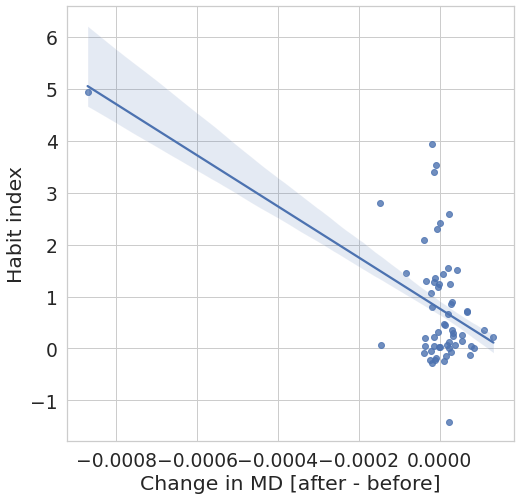

In [59]:
std_for_outliers = 9999999
behav_short_no_outiers = behav_short[(behav_short['change_in_MD_vmPFC'] > (np.mean(behav_short['change_in_MD_vmPFC']) - std_for_outliers*np.std(behav_short['change_in_MD_vmPFC']))) & (behav_short['change_in_MD_vmPFC'] < (np.mean(behav_short['change_in_MD_vmPFC']) + std_for_outliers*np.std(behav_short['change_in_MD_vmPFC'])))]

sns.set(font_scale = 1.7)
sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=1,figsize=(8,8))
sns.regplot(x="change_in_MD_vmPFC", y="habit_index", data=behav_short_no_outiers, ci=68, ax=axs);
axs.set(ylabel='Habit index', xlabel='Change in MD [after - before]')


In [42]:
behav_short.corr(method='spearman')
print(pearsonr(behav_short_no_outiers['change_in_MD_vmPFC'], behav_short_no_outiers['habit_index']))
print(spearmanr(behav_short_no_outiers['change_in_MD_vmPFC'], behav_short_no_outiers['habit_index']))

(0.08793792453174372, 0.5077811747235634)
SpearmanrResult(correlation=0.09136610884631291, pvalue=0.49131283143111515)


### REPEAT without 159 who is a crazy outliers (>7SD in both directions)

In [74]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.5')

Test for POSITIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: vmPFC | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
2	3	0.697	50	97	25	51	97	25	3.73	51	97	25	3.38
1	2	0.626	46	93	30	46.5	93	30	4.69	47	93	30	4.08

Test for NEGATIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: vmPFC | group: SHORT ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	2	0.524	40	92	23	40.5	92.5	23	3.82	40	92	23	3.62



## LONG TRAINING

In [95]:
group = 'LONG'

### Whole brain - FA

In [96]:
map_type='FA'
region='whole_brain'

In [85]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- LONG training group | FA | whole_brain ---



In [86]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: whole_brain | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: whole_brain | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT: NOTHING

### Putamen - FA

In [87]:
region='Putamen'

In [88]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- LONG training group | FA | Putamen ---



In [89]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: Putamen | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: Putamen | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT : NOTHING

### Caudate - FA

In [90]:
region='Caudate'

In [91]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- LONG training group | FA | Caudate ---



In [92]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: Caudate | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: Caudate | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT : NOTHING

### vmPFC - FA

In [97]:
region='vmPFC'

In [98]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- LONG training group | FA | vmPFC ---



In [99]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: vmPFC | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	4	0.95	50	94	31	50.2	94.8	31.7	4.22	51	95	33	3.77

Test for NEGATIVE relationship between:
--- increase in FA and GOAL-DIRECTEDNESS in: vmPFC | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT : NOTHING

### Whole brain - MD

In [96]:
map_type='MD'
region='whole_brain'

In [97]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- LONG training group | MD | whole_brain ---



In [98]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: whole_brain | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: whole_brain | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT : NOTHING - marginal but it is really outside the brain close to vmPFC

### Putamen - MD

In [99]:
region='Putamen'

In [100]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- LONG training group | MD | Putamen ---



In [101]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: Putamen | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: Putamen | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT : NOTHING

### Caudate - MD

In [102]:
region='Caudate'

In [103]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- LONG training group | MD | Caudate ---



In [104]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: Caudate | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: Caudate | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT : NOTHING

### vmPFC - MD

In [105]:
region='vmPFC'

In [106]:
runRandomiseIndividualDiffs(group, map_type, region)

Running randomise for individual differences:
--- LONG training group | MD | vmPFC ---



In [107]:
getClusterInfoIndividualDiffs(group, map_type, region, ReversedSigThresh='0.90')

Test for POSITIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: vmPFC | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test for NEGATIVE relationship between:
--- increase in MD and GOAL-DIRECTEDNESS in: vmPFC | group: LONG ---

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	5	0.924	50	95	33	48.8	95.6	34.2	3.59	49	96	35	3.27



>>>>> RESULTS: NOTHING

# *-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

# Statistics - Exploratory SUBGROUPS analysis (subgroups of habitual and goal-directed participants are inferred based on the behavioral measure)

In [86]:
# Get the behavioral data:
behav_clustered_all = pd.read_csv(os.path.join(behav_data_path, 'clustered_subgroups_HIS_May_2022.csv'))
# remove subjects that don't have DTI data
absent_from_DTI_data2 = [sub for sub in behav_clustered_all.ID if 'sub-' + str(sub) not in subjFoldersDTI]
behav_clustered_all = behav_clustered_all[~behav_clustered_all.ID.isin(absent_from_DTI_data2)]

# remove subjects that were excluded from the behavioral sub-groups clusters:
absent_from_behav_clusters = [sub for sub in subjFoldersDTI if int(sub.split('-')[1]) not in list(behav_clustered_all.ID)]
subjFoldersDTI_forSubgroups = [sub for sub in subjFoldersDTI if sub not in absent_from_behav_clusters]

# now make sure that subject lists are matching:
if not ['sub-' + str(sub) for sub in behav_clustered_all.ID] == subjFoldersDTI_forSubgroups:
    raise Exception('Subject lists are not matching')
    #pass # for debugging

# create variables foreach group seperately and for the subgroups seperately:
behav_clustered_short = behav_clustered_all[behav_clustered_all.ID < 200]
behav_clustered_long = behav_clustered_all[behav_clustered_all.ID > 200]
behav_clustered_goal_directed = behav_clustered_all[behav_clustered_all.Cluster == 'Goal-directed']
behav_clustered_habitual = behav_clustered_all[behav_clustered_all.Cluster == 'Habitual']

# sort the data according to the subgroups and create matching lists for the DTI data:
behav_clustered_short = behav_clustered_short.sort_values(by=['Cluster', 'ID']).reset_index(drop=True)
subjFoldersDTI_clustered_short = ['sub-' + str(sub) for sub in behav_clustered_short.ID]

behav_clustered_long = behav_clustered_long.sort_values(by=['Cluster', 'ID']).reset_index(drop=True)
subjFoldersDTI_clustered_long = ['sub-' + str(sub) for sub in behav_clustered_long.ID]

behav_clustered_goal_directed = behav_clustered_goal_directed.sort_values(by=['ID']).reset_index(drop=True)
subjFoldersDTI_clustered_goal_directed = ['sub-' + str(sub) for sub in behav_clustered_goal_directed.ID]

behav_clustered_habitual = behav_clustered_habitual.sort_values(by=['ID']).reset_index(drop=True)
subjFoldersDTI_clustered_habitual = ['sub-' + str(sub) for sub in behav_clustered_habitual.ID]

In [87]:
subjFoldersDTI_clustered_short #goal-directed then habitual - from behav_clustered_short
subjFoldersDTI_clustered_long #goal-directed then habitual - from behav_clustered_long
subjFoldersDTI_clustered_goal_directed #1-day then 3-day - from behav_clustered_goal_directed
subjFoldersDTI_clustered_habitual #1-day then 3-day - from behav_clustered_habitual


['sub-104',
 'sub-106',
 'sub-108',
 'sub-113',
 'sub-114',
 'sub-115',
 'sub-117',
 'sub-118',
 'sub-121',
 'sub-122',
 'sub-126',
 'sub-129',
 'sub-130',
 'sub-138',
 'sub-141',
 'sub-142',
 'sub-143',
 'sub-146',
 'sub-147',
 'sub-148',
 'sub-149',
 'sub-150',
 'sub-152',
 'sub-153',
 'sub-155',
 'sub-156',
 'sub-160',
 'sub-162',
 'sub-164',
 'sub-166',
 'sub-167',
 'sub-172',
 'sub-205',
 'sub-210',
 'sub-212',
 'sub-215',
 'sub-218',
 'sub-229',
 'sub-230',
 'sub-232',
 'sub-239',
 'sub-240',
 'sub-243',
 'sub-245',
 'sub-247',
 'sub-249',
 'sub-251',
 'sub-252',
 'sub-254',
 'sub-257',
 'sub-258',
 'sub-260',
 'sub-261',
 'sub-262',
 'sub-263',
 'sub-264',
 'sub-265',
 'sub-270',
 'sub-271',
 'sub-272',
 'sub-281',
 'sub-282',
 'sub-283',
 'sub-285']

### prepare the design matrix

In [88]:
print('> Create the between group design matrix (of the calculated differences) - same is unpaired t-test (on the after-before differences)')
# create the folder
try:
    os.makedirs(os.path.join(models_path, 'sub_groups'), exist_ok=False)
    print('>> Created folder: ' + os.path.join(models_path, 'sub_groups'))
except:
    pass

# create the design matrix and contrasts:
N_goal_directed_in_clustered_1_DAY = behav_clustered_short.Cluster.value_counts()['Goal-directed']
N_habitual_in_clustered_1_DAY = behav_clustered_short.Cluster.value_counts()['Habitual']
print(f"design_ttest2 {os.path.join(models_path, 'sub_groups','design_unpaired_ttest_subgroups_in_1_Day')} {N_goal_directed_in_clustered_1_DAY} {N_habitual_in_clustered_1_DAY}")
os.system(f"design_ttest2 {os.path.join(models_path, 'sub_groups','design_unpaired_ttest_subgroups_in_1_Day')} {N_goal_directed_in_clustered_1_DAY} {N_habitual_in_clustered_1_DAY}")

N_goal_directed_in_clustered_3_DAY = behav_clustered_long.Cluster.value_counts()['Goal-directed']
N_habitual_in_clustered_3_DAY = behav_clustered_long.Cluster.value_counts()['Habitual']
print(f"design_ttest2 {os.path.join(models_path, 'sub_groups','design_unpaired_ttest_subgroups_in_3_Day')} {N_goal_directed_in_clustered_3_DAY} {N_habitual_in_clustered_3_DAY}")
os.system(f"design_ttest2 {os.path.join(models_path, 'sub_groups','design_unpaired_ttest_subgroups_in_3_Day')} {N_goal_directed_in_clustered_3_DAY} {N_habitual_in_clustered_3_DAY}")

N_1_DAY_in_clustered_goal_directed = len(set([sub for sub in subjFoldersDTI_clustered_goal_directed if int(sub.split('-')[-1])<200]))
N_3_DAY_in_clustered_goal_directed = len(set([sub for sub in subjFoldersDTI_clustered_goal_directed if int(sub.split('-')[-1])>200]))
print(f"design_ttest2 {os.path.join(models_path, 'sub_groups','design_unpaired_ttest_subgroups_in_Goal_Directed')} {N_1_DAY_in_clustered_goal_directed} {N_3_DAY_in_clustered_goal_directed}")
os.system(f"design_ttest2 {os.path.join(models_path, 'sub_groups','design_unpaired_ttest_subgroups_in_Goal_Directed')} {N_1_DAY_in_clustered_goal_directed} {N_3_DAY_in_clustered_goal_directed}")

N_1_DAY_in_clustered_habitual = len(set([sub for sub in subjFoldersDTI_clustered_habitual if int(sub.split('-')[-1])<200]))
N_3_DAY_in_clustered_habitual = len(set([sub for sub in subjFoldersDTI_clustered_habitual if int(sub.split('-')[-1])>200]))
print(f"design_ttest2 {os.path.join(models_path, 'sub_groups','design_unpaired_ttest_subgroups_in_Habitual')} {N_1_DAY_in_clustered_habitual} {N_3_DAY_in_clustered_habitual}")
os.system(f"design_ttest2 {os.path.join(models_path, 'sub_groups','design_unpaired_ttest_subgroups_in_Habitual')} {N_1_DAY_in_clustered_habitual} {N_3_DAY_in_clustered_habitual}")


> Create the between group design matrix (of the calculated differences) - same is unpaired t-test (on the after-before differences)
design_ttest2 /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/models/sub_groups/design_unpaired_ttest_subgroups_in_1_Day 27 32
design_ttest2 /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/models/sub_groups/design_unpaired_ttest_subgroups_in_3_Day 19 32
design_ttest2 /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/models/sub_groups/design_unpaired_ttest_subgroups_in_Goal_Directed 27 19
design_ttest2 /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/models/sub_groups/design_unpaired_ttest_subgroups_in_Habitual 32 32


0

### Create one file with each group's participants together

In [89]:
for map_type in ['MD','FA']:          
    print(f"fslmerge -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_SUBGROUPS_in_1_Day_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_clustered_short])}")
    os.system(f"fslmerge -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_SUBGROUPS_in_1_Day_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_clustered_short])}")

    print(f"fslmerge -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_SUBGROUPS_in_3_Day_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_clustered_long])}")
    os.system(f"fslmerge -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_SUBGROUPS_in_3_Day_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_clustered_long])}")

    print(f"fslmerge -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_SUBGROUPS_in_Goal_Directed_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_clustered_goal_directed])}")
    os.system(f"fslmerge -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_SUBGROUPS_in_Goal_Directed_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_clustered_goal_directed])}")

    print(f"fslmerge -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_SUBGROUPS_in_Habitual_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_clustered_habitual])}")
    os.system(f"fslmerge -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_SUBGROUPS_in_Habitual_AFTER_minus_BEFORE_{map_type}')} {' '.join([os.path.join(stats_path, map_type, f'{sub}_in-MNI_{map_type}_AFTER-minus-BEFORE.nii.gz') for sub in subjFoldersDTI_clustered_habitual])}")
    

fslmerge -t /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg_NOTOPUP_EXCLUDED/MD/NOTOPUP_EXCLUDED_SUBGROUPS_in_1_Day_AFTER_minus_BEFORE_MD /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-103_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-107_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-119_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-120_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-124_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-127_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-128_in-MNI_MD_AFTER-minus-BEFORE.nii.gz /export2/DATA/HIS/HIS_server/analysis/dwi_data/stats_alt_reg/MD/sub-131_in-MNI_MD_AFTER-minus

### Settings

In [90]:
# a function to run randomise for the individual differences analyses:
def runRandomiseSubgroups(subgroups_in, map_type, region):
    print(f'Running randomise for sub-groups analysis:\n--- Subgroups in {subgroups_in} | {map_type} | {region} ---\n')
    #print(f'MAKE SURE TO REPLACE IN THE FUNCTION THE the print to os.system before running the command !!!\n')
    os.system(f"randomise_parallel \
        -i {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_SUBGROUPS_in_{subgroups_in}_AFTER_minus_BEFORE_{map_type}')} \
        -o {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_SUBGROUPS_in_{subgroups_in}_AFTER_minus_BEFORE_{map_type}_{region}')} \
        {'' if region=='whole_brain' else f'-m {masks_paths[region]}'} \
        -d {os.path.join(stats_path_NOTOPUP_EXCLUDED, 'models', 'sub_groups', f'design_unpaired_ttest_subgroups_in_{subgroups_in}.mat')} \
        -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, 'models', 'sub_groups', f'design_unpaired_ttest_subgroups_in_{subgroups_in}.con')}  \
        -n 6000 -C 3.1")

def runRandomiseSubgroups_ALL_TERMINAL(subgroups_optionalGroups, map_types, regions):
    commandList = []
    for subgroups_in in subgroups_optionalGroups:
        for map_type in map_types:
            for region in regions:
                print(f'Running randomise for sub-groups analysis:\n--- Subgroups in {subgroups_in} | {map_type} | {region} ---\n')
                commandList.append(f"randomise_parallel \
                    -i {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_SUBGROUPS_in_{subgroups_in}_AFTER_minus_BEFORE_{map_type}')} \
                    -o {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f'NOTOPUP_EXCLUDED_SUBGROUPS_in_{subgroups_in}_AFTER_minus_BEFORE_{map_type}_{region}')} \
                    {'' if region=='whole_brain' else f'-m {masks_paths[region]}'} \
                    -d {os.path.join(stats_path_NOTOPUP_EXCLUDED, 'models', 'sub_groups', f'design_unpaired_ttest_subgroups_in_{subgroups_in}.mat')} \
                    -t {os.path.join(stats_path_NOTOPUP_EXCLUDED, 'models', 'sub_groups', f'design_unpaired_ttest_subgroups_in_{subgroups_in}.con')}  \
                    -n 6000 -C 3.1 && ")
    commandList[-1] = commandList[-1][:-3]
    return ''.join(commandList)


# Get cluster info:
def getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90'):
    print(f'Testing stats for sub-groups analysis:\n--- Subgroups in {subgroups_in} | {map_type} | {region} ---\n')
    print(f'Goal-directed > Test Habitual \n' if subgroups_in in ['1_Day','3_Day'] else f'1-Day > 3-Day\n')
    print(os.popen(f'cluster \
        -i {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_SUBGROUPS_in_{subgroups_in}_AFTER_minus_BEFORE_{map_type}_{region}_clusterm_corrp_tstat1.nii.gz")} \
        -c {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_SUBGROUPS_in_{subgroups_in}_AFTER_minus_BEFORE_{map_type}_{region}_tstat1.nii.gz")}\
        -t {ReversedSigThresh} \
        --scalarname=corrp' + '"1-p"').read())

    print(f'Test Habitual > Goal-Directed \n' if subgroups_in in ['1_Day','3_Day'] else f'3-Day > 1-Day\n')
    print(os.popen(f'cluster \
        -i {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_SUBGROUPS_in_{subgroups_in}_AFTER_minus_BEFORE_{map_type}_{region}_clusterm_corrp_tstat2.nii.gz")} \
        -c {os.path.join(stats_path_NOTOPUP_EXCLUDED, map_type, f"NOTOPUP_EXCLUDED_SUBGROUPS_in_{subgroups_in}_AFTER_minus_BEFORE_{map_type}_{region}_tstat2.nii.gz")}\
        -t {ReversedSigThresh} \
        --scalarname=corrp' + '"1-p"').read())


## ALTERNATIVE: Run in terminal and summarize the results

In [94]:
command = runRandomiseSubgroups_ALL_TERMINAL(subgroups_optionalGroups=['1_Day', '3_Day'], map_types=['FA', 'MD'], regions=['whole_brain', 'Putamen', 'Caudate', 'vmPFC'])
print(command)

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | FA | whole_brain ---

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | FA | Putamen ---

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | FA | Caudate ---

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | FA | vmPFC ---

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | MD | whole_brain ---

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | MD | Putamen ---

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | MD | Caudate ---

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | MD | vmPFC ---

Running randomise for sub-groups analysis:
--- Subgroups in 3_Day | FA | whole_brain ---

Running randomise for sub-groups analysis:
--- Subgroups in 3_Day | FA | Putamen ---

Running randomise for sub-groups analysis:
--- Subgroups in 3_Day | FA | Caudate ---

Running randomise for sub-groups analysis:
---

In [115]:
# Get cluster info:
for subgroups_in in ['1_Day', '3_Day']:
    for map_type in ['FA', 'MD']:
        for region in ['whole_brain', 'Putamen', 'Caudate', 'vmPFC']:
            getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 1_Day | FA | whole_brain ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Testing stats for sub-groups analysis:
--- Subgroups in 1_Day | FA | Putamen ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Ind

## IN SHORT TRAINING

In [120]:
subgroups_in = '1_Day'

### Whole brain - FA

In [121]:
map_type='FA'
region='whole_brain'

In [122]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | FA | whole_brain ---



In [123]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 1_Day | FA | whole_brain ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS: NOTHING

### Putamen - FA

In [124]:
region='Putamen'

In [125]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | FA | Putamen ---



In [126]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 1_Day | FA | Putamen ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	3	0.927	34	58	38	33.3	58	39	4.11	33	58	40	3.55

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS: NOTHING

### Caudate - FA

In [127]:
region='Caudate'

In [128]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | FA | Caudate ---



In [129]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 1_Day | FA | Caudate ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS:
MMM... need to look into it

### vmPFC - FA

In [130]:
region='vmPFC'

In [131]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | FA | vmPFC ---



In [132]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 1_Day | FA | vmPFC ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS: NOTHING

### Whole brain - MD

In [133]:
map_type='MD'
region='whole_brain'

In [134]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | MD | whole_brain ---



In [135]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 1_Day | MD | whole_brain ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS: NOTHING

### Putamen - MD

In [136]:
region='Putamen'

In [137]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | MD | Putamen ---



In [138]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 1_Day | MD | Putamen ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS: NOTHING

### Caudate - MD

In [139]:
region='Caudate'

In [140]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | MD | Caudate ---



In [141]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 1_Day | MD | Caudate ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS: NOTHING

### vmPFC - MD

In [142]:
region='vmPFC'

In [143]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 1_Day | MD | vmPFC ---



In [144]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 1_Day | MD | vmPFC ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	4	0.953	38	86	25	38.5	85.5	25.8	4.07	38	85	26	3.66

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS: NOTHING

## IN LONG TRAINING

In [91]:
subgroups_in = '3_Day'

### Whole brain - FA

In [92]:
map_type='FA'
region='whole_brain'

In [147]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 3_Day | FA | whole_brain ---



In [148]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 3_Day | FA | whole_brain ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	8	0.925	27	59	60	28.1	58.7	61.2	4.43	27	59	61	3.67

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	7	0.902	27	57	60	26.9	57.1	61.3	4.67	27	57	60	4.03



>>>>> RESULT:

### Putamen - FA

In [149]:
region='Putamen'

In [150]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 3_Day | FA | Putamen ---



In [151]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 3_Day | FA | Putamen ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT

### Caudate - FA

In [152]:
region='Caudate'

In [153]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 3_Day | FA | Caudate ---



In [154]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 3_Day | FA | Caudate ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	3	0.937	36	77	40	36	76.3	41	3.53	36	76	41	3.36

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	2	0.907	37	71	33	36.5	71.5	33	4.13	36	72	33	3.92



>>>>> RESULTS:

### vmPFC - FA

In [93]:
region='vmPFC'

In [94]:
runRandomiseSubgroups(subgroups_in, map_type, region)

NameError: name 'runRandomiseSubgroups' is not defined

In [157]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 3_Day | FA | vmPFC ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS:

### Whole brain - MD

In [158]:
map_type='MD'
region='whole_brain'

In [159]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 3_Day | MD | whole_brain ---



In [160]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 3_Day | MD | whole_brain ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT:

### Putamen - MD

In [161]:
region='Putamen'

In [162]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 3_Day | MD | Putamen ---



In [163]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 3_Day | MD | Putamen ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN
1	3	0.901	37	70	35	37.7	70.3	35	4.23	38	70	35	3.55

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULT

### Caudate - MD

In [164]:
region='Caudate'

In [165]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 3_Day | MD | Caudate ---



In [166]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 3_Day | MD | Caudate ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS:

### vmPFC - MD

In [167]:
region='vmPFC'

In [168]:
runRandomiseSubgroups(subgroups_in, map_type, region)

Running randomise for sub-groups analysis:
--- Subgroups in 3_Day | MD | vmPFC ---



In [169]:
# Get cluster info:
getClusterInfoSubgroups(subgroups_in, map_type, region, ReversedSigThresh='0.90')

Testing stats for sub-groups analysis:
--- Subgroups in 3_Day | MD | vmPFC ---

Goal-directed > Test Habitual 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN

Test Habitual > Goal-Directed 

Cluster Index	Voxels	corrp1-p-MAX	corrp1-p-MAX X (vox)	corrp1-p-MAX Y (vox)	corrp1-p-MAX Z (vox)	corrp1-p-COG X (vox)	corrp1-p-COG Y (vox)	corrp1-p-COG Z (vox)	COPE-MAX	COPE-MAX X (vox)	COPE-MAX Y (vox)	COPE-MAX Z (vox)	COPE-MEAN



>>>>> RESULTS: